In [29]:
import numpy as np
np.random.seed(42)  # 设置随机种子
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from tools.multi_layer_net import MultiLayerNet
from tools.functions import *
from tools.optimizer import SGD

# 1.下载数据集

In [30]:
# 定义数据转换操作，将图像转换为NumPy数组
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

# 下载数据集
train_set = torchvision.datasets.CIFAR10(root = './dataset', train = True, transform=transform, download = True)    # 训练集下载
test_set = torchvision.datasets.CIFAR10(root = './dataset', train = False, transform=transform, download = True)    # 测试集下载

Files already downloaded and verified
Files already downloaded and verified


# 2.数据集描述

In [31]:
# 提取数据和标签
x_train, y_train = train_set.data, train_set.targets
x_test, y_test = test_set.data, test_set.targets

print(x_train[0])  # 训练集中第一个数据
print(y_train[0])  # 训练集中第一个数据的标签

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
6


In [32]:
# 查看训练集和测试集的规模
print(f"训练集样本数量: {len(train_set)}")
print(f"测试集样本数量: {len(test_set)}")

# 查看训练集和测试集的形状
print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape: {x_test.shape}')

# 将标签转换为NumPy数组并查看形状
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# 查看标签的形状
print(f'y_train.shape: {y_train_np.shape}')
print(f'y_test.shape: {y_test_np.shape}')

训练集样本数量: 50000
测试集样本数量: 10000
x_train.shape: (50000, 32, 32, 3)
x_test.shape: (10000, 32, 32, 3)
y_train.shape: (50000,)
y_test.shape: (10000,)


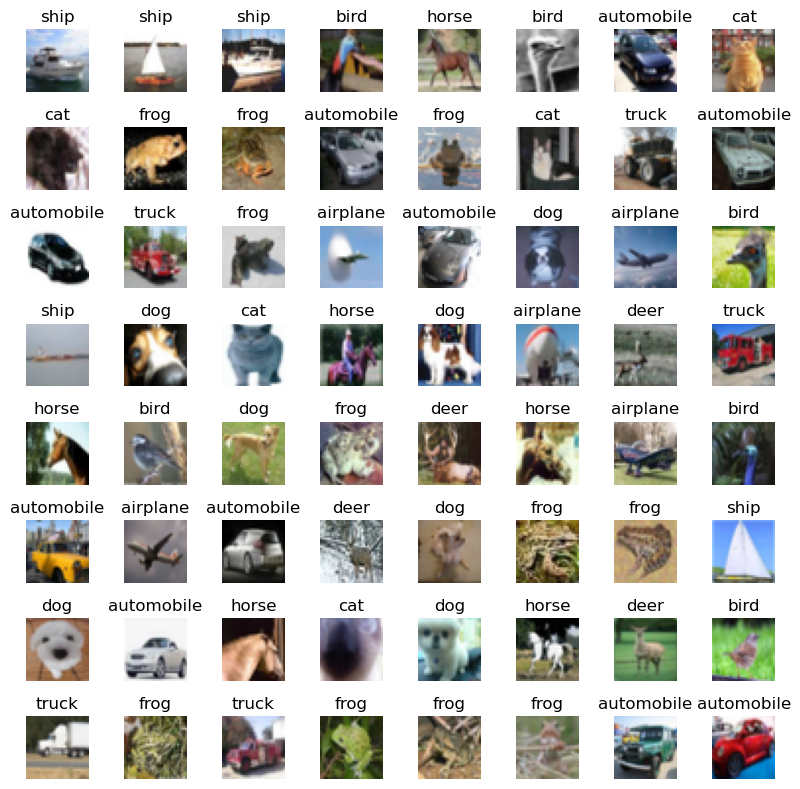

In [33]:
#查看部分训练集图片

# 获取训练集规模
m = x_train.shape[0]

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 可视化
fig,axes=plt.subplots(8,8,figsize=(8,8))    # 8x8

for i,ax in enumerate(axes.flat): 
    idx = np.random.randint(m)  # 随机数
    ax.imshow(x_train[idx])     # imshow():传入图片的像素矩阵
    ax.set_title(class_names[train_set.targets[idx]])   # 标签
    ax.axis('off')              # 移除坐标轴
plt.tight_layout()

# 3.预处理

In [34]:
# 图片展平
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# 归一化到[0,1]
x_train = x_train.astype(np.float32) / 255.0  
x_test = x_test.astype(np.float32) / 255.0

# one-hot编码
y_train = one_hot_encode(y_train, 10)
y_test = one_hot_encode(y_test, 10)

# 查看训练集和测试集的形状
print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape: {x_test.shape}')

x_train.shape: (50000, 3072)
x_test.shape: (10000, 3072)


In [35]:
# 划分训练集和验证集
validation_ratio = 0.2  # 验证集占训练集的比例
num_validation = int(x_train.shape[0] * validation_ratio)

# 随机打乱数据
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# 分割训练集和验证集
x_val = x_train[:num_validation]
y_val = y_train[:num_validation]
x_train = x_train[num_validation:]
y_train = y_train[num_validation:]

print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')

x_train.shape: (40000, 3072)
y_train.shape: (40000, 10)
x_val.shape: (10000, 3072)
y_val.shape: (10000, 10)


# 4.模型定义、训练与测试

In [36]:
# 构建模型
input_size = x_train.shape[1]   # 输入大小
hidden_size_list = [512, 128]   # 隐藏层大小
output_size = 10                # 输出大小（CIFAR-10有10个类别）
activation = 'relu'             # 激活函数类型
weight_init_std = 'relu'        # 权重初始化方式
weight_decay_lambda = 0.1       # L2正则化强度
dropout_ratio = 0.2             # Dropout比例，缓解过拟合
bn_flag=True                    # 批量归一化，缓解过拟合

model = MultiLayerNet(input_size, hidden_size_list, output_size, activation, weight_init_std, weight_decay_lambda, dropout_ratio,bn_flag)


In [37]:
# 定义训练参数
learning_rate = 0.01
optimizer = SGD(lr=learning_rate, decay_rate=0.95, decay_epoch=5)  # 设置学习率下降，每5个epoch下降一次
batch_size = 50
num_epochs = 20

# 训练循环
train_loss_list = []
val_loss_list = []
val_acc_list = []

num_train = x_train.shape[0]
iterations_per_epoch = max(num_train // batch_size, 1)
num_iterations = num_epochs * iterations_per_epoch

best_val_acc = 0
best_model_params = model.params.copy()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0
    epoch_val_loss = 0
    epoch_val_acc = 0

    for i in range(iterations_per_epoch):
        # 随机选择一个批量
        batch_mask = np.random.choice(num_train, batch_size)
        x_batch = x_train[batch_mask]
        y_batch = y_train[batch_mask]

        # 前向传播
        loss = model.loss(x_batch, y_batch)
        epoch_train_loss += loss

        # 反向传播
        grads = model.gradient(x_batch, y_batch)

        # 参数更新
        optimizer.update(model.params, grads)

    # 计算每个epoch的平均训练损失
    epoch_train_loss /= iterations_per_epoch
    train_loss_list.append(epoch_train_loss)

    # 验证集评估
    val_loss = model.loss(x_val, y_val)
    val_acc = model.accuracy(x_val, y_val)
    epoch_val_loss = val_loss
    epoch_val_acc = val_acc
    val_loss_list.append(epoch_val_loss)
    val_acc_list.append(epoch_val_acc)

    print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

    # 保存最佳模型
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_params = model.params.copy()

    # 调用学习率下降
    optimizer.decay_lr()

# 使用最佳模型参数
model.params = best_model_params

# 测试模型
test_acc = model.accuracy(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20
Training Loss: 34.2620, Validation Loss: 14.8935, Validation Accuracy: 0.4057
Epoch 2/20
Training Loss: 8.5260, Validation Loss: 4.6811, Validation Accuracy: 0.4314
Epoch 3/20
Training Loss: 3.3048, Validation Loss: 2.5007, Validation Accuracy: 0.4239
Epoch 4/20
Training Loss: 2.1606, Validation Loss: 1.9984, Validation Accuracy: 0.4434
Epoch 5/20
Training Loss: 1.8951, Validation Loss: 1.8860, Validation Accuracy: 0.4447
Epoch 6/20
Training Loss: 1.8197, Validation Loss: 1.8417, Validation Accuracy: 0.4523
Epoch 7/20
Training Loss: 1.8075, Validation Loss: 1.8489, Validation Accuracy: 0.4474
Epoch 8/20
Training Loss: 1.7956, Validation Loss: 1.8234, Validation Accuracy: 0.4550
Epoch 9/20
Training Loss: 1.7918, Validation Loss: 1.8237, Validation Accuracy: 0.4623
Epoch 10/20
Training Loss: 1.7942, Validation Loss: 1.8288, Validation Accuracy: 0.4636
Epoch 11/20
Training Loss: 1.8008, Validation Loss: 1.8471, Validation Accuracy: 0.4513
Epoch 12/20
Training Loss: 1.7936, Vali

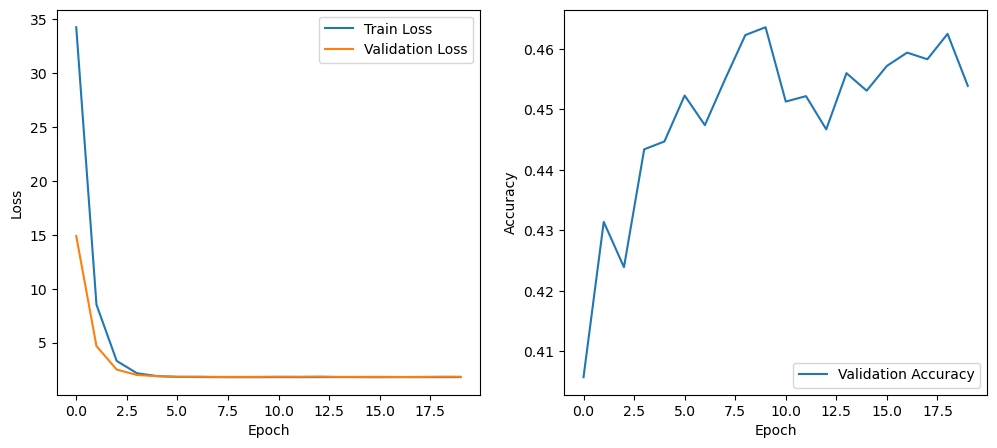

In [38]:
# 绘制训练过程
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 5.超参数查找

In [40]:
# 定义超参数范围
learning_rate_list = [0.005, 0.01]
hidden_size_list = [[512, 256], [512, 128], [256, 128]]
weight_decay_lambda_list = [0.001, 0.01, 0.1]

# 循环遍历超参数组合
results = []

for lr in learning_rate_list:
    for hidden_sizes in hidden_size_list:
        for weight_decay_lambda in weight_decay_lambda_list:
            print('=' * 50)
            print(f"Training with lr={lr}, hidden_sizes={hidden_sizes}, weight_decay_lambda={weight_decay_lambda}")
            
            # 构建模型
            model = MultiLayerNet(input_size, hidden_sizes, output_size, 
                                  activation='relu', 
                                  weight_init_std='relu', 
                                  weight_decay_lambda=weight_decay_lambda, 
                                  dropout_ratio=0.2, bn_flag=True)
            
            # 定义训练参数
            optimizer = SGD(lr=lr, decay_rate=0.95, decay_epoch=5)
            batch_size = 50
            num_epochs = 10
            
            # 计算每个 epoch 的迭代次数
            num_train = x_train.shape[0]
            iterations_per_epoch = max(num_train // batch_size, 1)
            num_iterations = num_epochs * iterations_per_epoch
            
            # 初始化记录列表
            train_loss_list = []
            val_loss_list = []
            val_acc_list = []
            
            best_val_acc = 0
            best_model_params = model.params.copy()  # 保存当前超参数组合的最佳模型参数
            
            for epoch in range(num_epochs):
                print(f"Epoch {epoch + 1}/{num_epochs}")
                epoch_train_loss = 0
                epoch_val_loss = 0
                epoch_val_acc = 0
                
                for i in range(iterations_per_epoch):
                    batch_mask = np.random.choice(num_train, batch_size)
                    x_batch = x_train[batch_mask]
                    y_batch = y_train[batch_mask]
                    
                    loss = model.loss(x_batch, y_batch)
                    epoch_train_loss += loss
                    
                    grads = model.gradient(x_batch, y_batch)
                    optimizer.update(model.params, grads)
                
                epoch_train_loss /= iterations_per_epoch
                train_loss_list.append(epoch_train_loss)
                
                val_loss = model.loss(x_val, y_val)
                val_acc = model.accuracy(x_val, y_val)
                epoch_val_loss = val_loss
                epoch_val_acc = val_acc
                val_loss_list.append(epoch_val_loss)
                val_acc_list.append(epoch_val_acc)
                
                print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")
                
                if epoch_val_acc > best_val_acc:
                    best_val_acc = epoch_val_acc
                    best_model_params = model.params.copy()  # 更新当前超参数组合的最佳模型参数
            
            # 使用当前超参数组合的最佳模型参数
            model.params = best_model_params
            
            # 测试模型
            test_acc = model.accuracy(x_test, y_test)
            print(f"Test Accuracy: {test_acc:.4f}")
            
            # 记录结果
            results.append({
                'lr': lr,
                'hidden_sizes': hidden_sizes,
                'weight_decay_lambda': weight_decay_lambda,
                'best_val_acc': best_val_acc,
                'test_acc': test_acc,
                'train_loss_list': train_loss_list,
                'val_loss_list': val_loss_list,
                'val_acc_list': val_acc_list,
                'best_model_params': best_model_params  # 保存当前超参数组合的最佳模型参数
            })


Training with lr=0.005, hidden_sizes=[512, 256], weight_decay_lambda=0.001
Epoch 1/10
Training Loss: 2.7321, Validation Loss: 2.5715, Validation Accuracy: 0.3581
Epoch 2/10
Training Loss: 2.5090, Validation Loss: 2.4655, Validation Accuracy: 0.3941
Epoch 3/10
Training Loss: 2.4115, Validation Loss: 2.4095, Validation Accuracy: 0.4172
Epoch 4/10
Training Loss: 2.3554, Validation Loss: 2.3611, Validation Accuracy: 0.4274
Epoch 5/10
Training Loss: 2.3021, Validation Loss: 2.3281, Validation Accuracy: 0.4334
Epoch 6/10
Training Loss: 2.2684, Validation Loss: 2.2998, Validation Accuracy: 0.4435
Epoch 7/10
Training Loss: 2.2241, Validation Loss: 2.2722, Validation Accuracy: 0.4532
Epoch 8/10
Training Loss: 2.2044, Validation Loss: 2.2594, Validation Accuracy: 0.4516
Epoch 9/10
Training Loss: 2.1717, Validation Loss: 2.2335, Validation Accuracy: 0.4641
Epoch 10/10
Training Loss: 2.1352, Validation Loss: 2.2104, Validation Accuracy: 0.4665
Test Accuracy: 0.4798
Training with lr=0.005, hidden_s

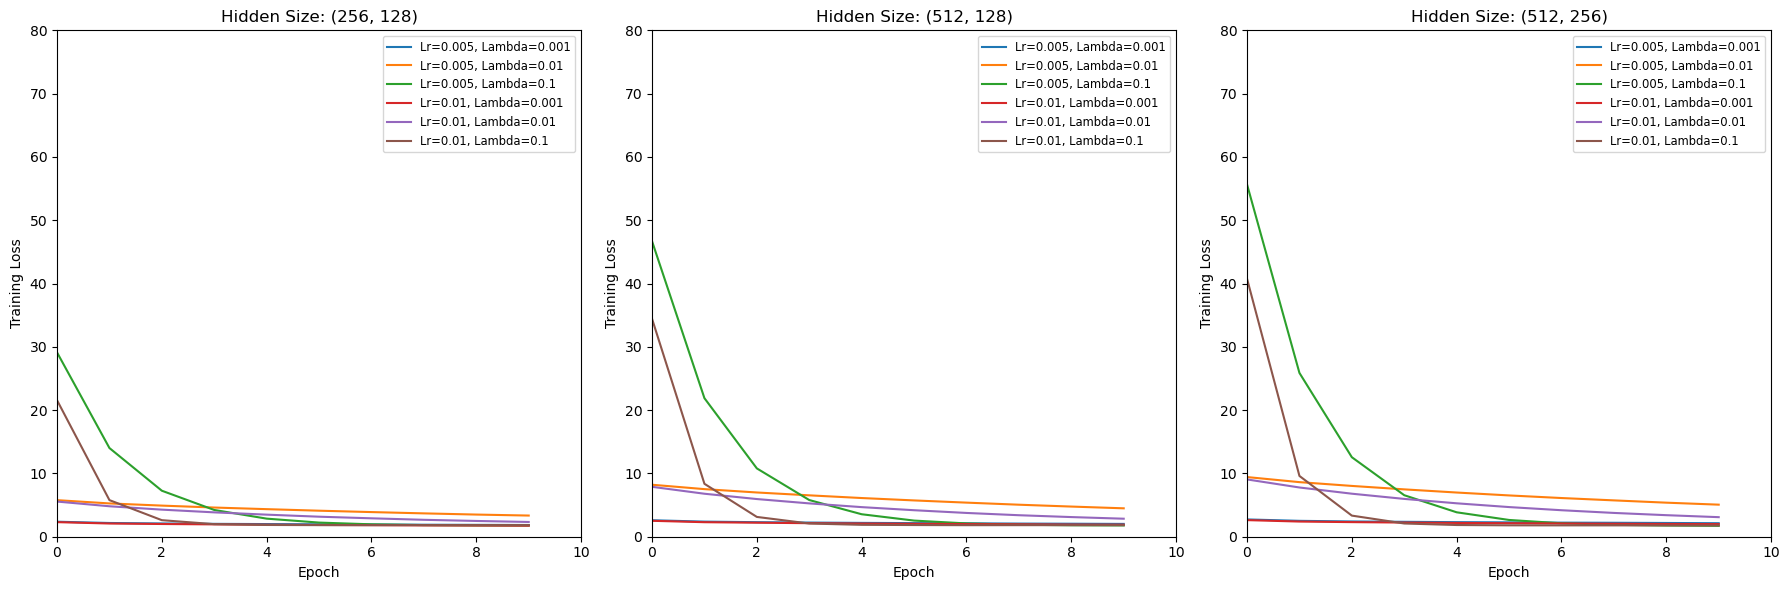

In [41]:
# 绘制不同超参数组合的训练损失曲线

# 获取所有的 hidden_size 的唯一值，并转换为元组
hidden_sizes = sorted({tuple(result['hidden_sizes']) for result in results})

# 创建一个 1 行 4 列的子图布局
fig, axes = plt.subplots(1, len(hidden_sizes), figsize=(18, 6))
if len(hidden_sizes) == 1:
    axes = [axes]  # 如果只有一个子图，使其成为列表

# 设置统一的 x 轴和 y 轴范围
x_min, x_max = 0, 10
y_min, y_max = 0, 80

# 为每种 hidden_size 创建一个子图
for i, hidden_size in enumerate(hidden_sizes):
    ax = axes[i]
    ax.set_title(f'Hidden Size: {hidden_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    
    # 筛选出当前 hidden_size 的结果
    current_results = [result for result in results if tuple(result['hidden_sizes']) == hidden_size]
    
    # 在子图中绘制不同 lambda 和 lr 的训练损失曲线
    for result in current_results:
        ax.plot(result['train_loss_list'], label=f"Lr={result['lr']}, Lambda={result['weight_decay_lambda']}")
    
    ax.legend(loc='upper right', fontsize='small')
    ax.set_xlim(x_min, x_max)  # 设置 x 轴范围
    ax.set_ylim(y_min, y_max)  # 设置 y 轴范围

plt.tight_layout()
plt.show()

In [42]:
# 找到最佳超参数组合
best_result = max(results, key=lambda x: x['best_val_acc'])
print(f"Best Validation Accuracy: {best_result['best_val_acc']:.4f}")
print(f"Best Test Accuracy: {best_result['test_acc']:.4f}")
print(f"Best Hyperparameters: lr={best_result['lr']}, hidden_sizes={best_result['hidden_sizes']}, weight_decay_lambda={best_result['weight_decay_lambda']}")

Best Validation Accuracy: 0.4902
Best Test Accuracy: 0.4948
Best Hyperparameters: lr=0.01, hidden_sizes=[512, 128], weight_decay_lambda=0.01


In [43]:
# 保存最佳超参数组合对应的模型参数
import pickle

def save_model_params_with_pickle(model_params, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model_params, f)
    print(f"Model parameters saved to {filename}")

best_model_filename = "best_model_params.pkl"
save_model_params_with_pickle(best_result['best_model_params'], best_model_filename)
print(f"Best model parameters saved to {best_model_filename}")

Model parameters saved to best_model_params.pkl
Best model parameters saved to best_model_params.pkl
